<a href="https://colab.research.google.com/github/23520052/DoAnDuLieuLon/blob/main/1_Data_Analysis_and_EDA_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bước 1: Kết nối Google Drive và Trỏ đến thư mục chứa dữ liệu**


In [2]:
# 1. Kết nối với Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os

# --- QUAN TRỌNG: SỬA ĐƯỜNG DẪN DƯỚI ĐÂY ---
# Hãy thay đổi đường dẫn này trỏ đúng vào thư mục lưu file trên Drive
folder_path = '/content/drive/My Drive/ABSA_Project'

try:
    os.chdir(folder_path)
    print(f"Đã chuyển đến thư mục: {os.getcwd()}")

    # Kiểm tra xem có file dữ liệu ở đây không
    print("Danh sách file trong thư mục:")
    print(os.listdir())
except Exception as e:
    print(f"Lỗi đường dẫn: {e}")
    print("Bạn hãy kiểm tra lại đường dẫn folder_path nhé!")

Mounted at /content/drive
Đã chuyển đến thư mục: /content/drive/My Drive/ABSA_Project
Danh sách file trong thư mục:
['3-VLSP2018-SA-Restaurant-test.csv', '2-VLSP2018-SA-Restaurant-dev.csv', '1-VLSP2018-SA-Restaurant-train.csv', '3-VLSP2018-SA-Restaurant-test.txt', '1-VLSP2018-SA-Restaurant-train.txt', '2-VLSP2018-SA-Restaurant-dev.txt', '1-VLSP2018-Restaurant-Train-BALANCED.csv', '1-VLSP2018-Restaurant-Train-BACKTRANS.csv']


# **Bước 2: Hàm xử lý dữ liệu (Parser)**
Vì file .txt của VLSP có định dạng riêng (một dòng review, sau đó là dòng chứa các nhãn trong dấu {}), chúng ta cần hàm này để "dịch" nó sang dạng bảng.

In [3]:
import pandas as pd
import re

def parse_vlsp_data(file_name):
    """
    Hàm đọc file txt định dạng VLSP 2018 (Review + {Aspect, Sentiment})
    """
    try:
        # Thử đọc với utf-16 (định dạng thường gặp của file gốc VLSP)
        with open(file_name, 'r', encoding='utf-16') as f:
            lines = f.readlines()
    except:
        # Nếu lỗi, thử đọc với utf-8
        with open(file_name, 'r', encoding='utf-8') as f:
            lines = f.readlines()

    dataset = []
    review_buffer = []

    # Regex để tìm nhãn: {ASPECT, SENTIMENT}
    label_pattern = re.compile(r"\{(.*?),\s*(.*?)\}")

    for line in lines:
        line = line.strip()
        if not line: continue # Bỏ qua dòng trống

        # Nếu dòng chứa ký tự '{' và '}', ta coi đó là dòng chứa nhãn
        if "{" in line and "}" in line and "#" in line:
            # Gộp các dòng review trước đó lại thành 1 câu hoàn chỉnh
            current_review = " ".join(review_buffer).strip()

            # Tìm tất cả các cặp (Aspect, Sentiment) trong dòng đó
            matches = label_pattern.findall(line)

            for aspect, sentiment in matches:
                # Chỉ lấy dữ liệu nếu sentiment không phải là 'none' (nếu có)
                if sentiment.lower() != 'none':
                    dataset.append({
                        'text': current_review,
                        'aspect': aspect.strip(),
                        'label': sentiment.strip().lower() # chuyển về chữ thường (positive/negative)
                    })

            # Xóa buffer để chuẩn bị cho review tiếp theo
            review_buffer = []
        else:
            # Đây là dòng nội dung review
            # Xóa các ký tự đầu dòng như "_ " hoặc "- " mà dữ liệu hay có
            clean_line = re.sub(r"^[\_\-]\s*", "", line)
            review_buffer.append(clean_line)

    return pd.DataFrame(dataset)

print("Đã khai báo xong hàm xử lý dữ liệu!")

Đã khai báo xong hàm xử lý dữ liệu!


# **Bước 3: Load dữ liệu và hiển thị**

In [4]:
# Tên file .txt đã upload
file_train_name = '1-VLSP2018-SA-Restaurant-train.txt'

try:
    # Gọi hàm xử lý ở Bước 2
    df_train = parse_vlsp_data(file_train_name)

    print("--- ĐỌC DỮ LIỆU THÀNH CÔNG ---")
    print(f"Tổng số mẫu dữ liệu (Cặp câu + khía cạnh): {len(df_train)}")

    # Hiển thị 5 dòng ngẫu nhiên để kiểm tra
    display(df_train.sample(5))

except Exception as e:
    print("Gặp lỗi khi đọc file:", e)
    print("Gợi ý: Kiểm tra lại tên file xem có đúng đuôi .txt không?")

--- ĐỌC DỮ LIỆU THÀNH CÔNG ---
Tổng số mẫu dữ liệu (Cặp câu + khía cạnh): 9297


,text,aspect,label
8186,"#2571 Rất ngon mắt lẫn ngon miệng nhé, bún chả...",FOOD#STYLE&OPTIONS,positive
3029,#922 Đây là một trong những cửa tiệm bột chiên...,FOOD#QUALITY,positive
2412,"#728 Chỗ này nổi tiếng món khô bò lâu năm, ngo...",RESTAURANT#GENERAL,positive
6618,"#2140 Nước lẩu 2 loại đều ngon. Rất đậm đà, ăn...",FOOD#STYLE&OPTIONS,positive
8565,"#2707 thích ăn sasin q5 nhất, mì ngon ăn cấp 1...",AMBIENCE#GENERAL,positive


# **Bước 4: Vẽ biểu đồ phân bố (Minh chứng Mất cân bằng)**


Số lượng cụ thể:
label
positive    7071
neutral     1556
negative     670
Name: count, dtype: int64


/tmp/ipython-input-1333972943.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=colors)


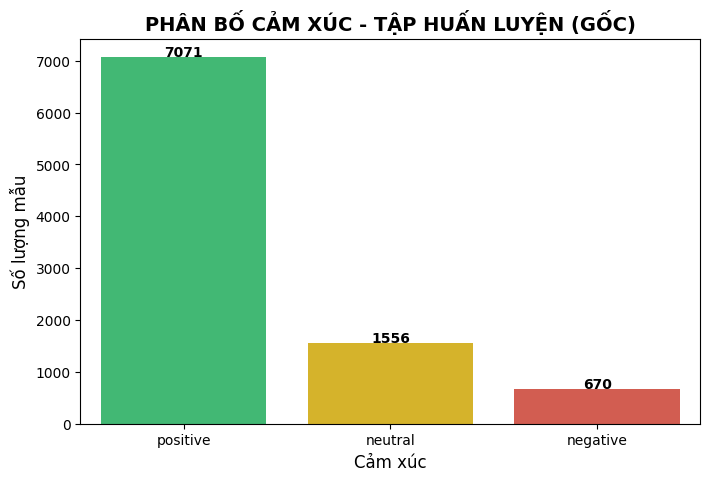

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Đếm số lượng từng nhãn
sentiment_counts = df_train['label'].value_counts()
print("\nSố lượng cụ thể:")
print(sentiment_counts)

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
# Dùng màu sắc để phân biệt: Pos=Xanh, Neg=Đỏ, Neu=Vàng/Xám
colors = {'positive': '#2ecc71', 'negative': '#e74c3c', 'neutral': '#f1c40f'}

sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=colors)

plt.title('PHÂN BỐ CẢM XÚC - TẬP HUẤN LUYỆN (GỐC)', fontsize=14, fontweight='bold')
plt.xlabel('Cảm xúc', fontsize=12)
plt.ylabel('Số lượng mẫu', fontsize=12)

# Hiển thị con số trên đầu cột
for index, value in enumerate(sentiment_counts.values):
    plt.text(index, value + 20, str(value), ha='center', fontweight='bold')

plt.show()

In [ ]:
# Tên file chính xác
file_dev_name = '2-VLSP2018-SA-Restaurant-dev.txt'
file_test_name = '3-VLSP2018-SA-Restaurant-test.txt'

try:
    print("--- ĐANG TẢI TẬP DEV & TEST ---")

    # 1. Load tập Dev
    df_dev = parse_vlsp_data(file_dev_name)
    print(f" Đã tải tập Dev: {len(df_dev)} mẫu")

    # 2. Load tập Test
    df_test = parse_vlsp_data(file_test_name)
    print(f" Đã tải tập Test: {len(df_test)} mẫu")

    # 3. Kiểm tra phân bố tập Test (Để xem nó có mất cân bằng giống tập Train không)
    print("\nPhân bố nhãn trên tập Test (Dữ liệu thực tế để chấm điểm):")
    print(df_test['label'].value_counts())

except Exception as e:
    print(" Lỗi:", e)
    print("Bạn nhớ kiểm tra lại tên file nhé!")

--- ĐANG TẢI TẬP DEV & TEST ---
 Đã tải tập Dev: 3443 mẫu
 Đã tải tập Test: 2419 mẫu

Phân bố nhãn trên tập Test (Dữ liệu thực tế để chấm điểm):
label
positive    1669
neutral      591
negative     159
Name: count, dtype: int64


# **Áp dụng phương pháp EDA (Easy Data Augmentation)**
**BƯỚC 1: Cài đặt thư viện tách từ**

Để đảo từ hoặc xóa từ tiếng Việt chính xác, ta cần biết đâu là một từ (ví dụ: "nhà hàng" là 1 từ, không được tách thành "nhà" và "hàng"). Ta sẽ dùng underthesea.

In [6]:
# Cài đặt thư viện xử lý tiếng Việt
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.4/978.4 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.2 MB/s eta 0:00:00


**BƯỚC 2: Viết hàm Tăng cường dữ liệu (EDA)**

2 kỹ thuật chính:

Random Swap: Đảo vị trí 2 từ ngẫu nhiên (Giữ nguyên ngữ nghĩa, thay đổi cấu trúc).

Random Deletion: Xóa ngẫu nhiên 1 từ (Giúp mô hình bớt phụ thuộc vào từ cụ thể).

In [7]:
import random
from underthesea import word_tokenize

# Hàm 1: Đảo vị trí ngẫu nhiên 2 từ trong câu
def random_swap(sentence, n=1):
    words = word_tokenize(sentence) # Tách từ tiếng Việt
    if len(words) < 2: return sentence

    new_words = words.copy()
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(new_words)), 2)
        # Hoán đổi
        new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]

    return " ".join(new_words)

# Hàm 2: Xóa ngẫu nhiên từ (với xác suất p)
def random_deletion(sentence, p=0.15):
    words = word_tokenize(sentence)
    if len(words) <= 1: return sentence

    # Chỉ giữ lại từ nếu random > p
    new_words = [w for w in words if random.uniform(0, 1) > p]

    # Nếu xui xẻo xóa hết thì trả về câu gốc
    if len(new_words) == 0: return sentence

    return " ".join(new_words)

# Hàm tổng hợp: Sinh ra một câu mới từ câu cũ
def augment_sentence(sentence):
    # Tung đồng xu để chọn phương pháp (50-50)
    if random.random() < 0.5:
        return random_swap(sentence)
    else:
        return random_deletion(sentence)

# Test thử xem hàm hoạt động không
sample = "Món ăn ở đây rất ngon và rẻ"
print("Gốc:", sample)
print("Augmented 1:", augment_sentence(sample))
print("Augmented 2:", augment_sentence(sample))

Gốc: Món ăn ở đây rất ngon và rẻ
Augmented 1: Món ăn ở đây ngon rất và rẻ
Augmented 2: rất ăn ở đây Món ngon và rẻ


**BƯỚC 3: Thực hiện cân bằng dữ liệu (Balancing Loop)**

Đây là bước "bơm" dữ liệu. Chúng ta sẽ lấy số lượng mẫu của nhãn nhiều nhất (Positive ~7000 mẫu) làm chuẩn. Các nhãn còn lại sẽ được nhân bản và biến đổi cho đến khi bằng số lượng đó.

In [8]:
from tqdm import tqdm # Thư viện tạo thanh loading bar cho đẹp

def balance_dataset(df):
    # 1. Tìm số lượng mẫu lớn nhất (Target count)
    max_count = df['label'].value_counts().max()
    print(f"Mục tiêu: Cân bằng tất cả các nhãn lên {max_count} mẫu")

    # 2. Tách dữ liệu theo từng nhãn
    groups = df.groupby('label')
    balanced_data = []

    for label, group_df in groups:
        # Lấy dữ liệu gốc của nhãn này
        samples = group_df.to_dict('records')
        current_count = len(samples)

        # Thêm dữ liệu gốc vào list kết quả
        balanced_data.extend(samples)

        # Tính số lượng cần sinh thêm
        augment_needed = max_count - current_count

        if augment_needed > 0:
            print(f"Dang tang cuong cho nhan '{label}': can them {augment_needed} mau...")

            # Sinh dữ liệu mới
            for _ in tqdm(range(augment_needed)):
                # Chọn ngẫu nhiên 1 mẫu cũ để làm gốc
                original_sample = random.choice(samples)

                # Tạo câu mới bằng kỹ thuật EDA
                new_text = augment_sentence(original_sample['text'])

                # Thêm vào list (giữ nguyên aspect và label, chỉ đổi text)
                balanced_data.append({
                    'text': new_text,
                    'aspect': original_sample['aspect'],
                    'label': original_sample['label']
                })

    return pd.DataFrame(balanced_data)

# --- CHẠY THỰC TẾ ---
# Tạo bộ dữ liệu mới đã cân bằng
df_train_balanced = balance_dataset(df_train)

print("\n--- HOÀN THÀNH TĂNG CƯỜNG ---")
print(f"Tổng số mẫu sau khi cân bằng: {len(df_train_balanced)}")

Mục tiêu: Cân bằng tất cả các nhãn lên 7071 mẫu
Dang tang cuong cho nhan 'negative': can them 6401 mau...


100%|██████████| 6401/6401 [00:29<00:00, 215.61it/s]


Dang tang cuong cho nhan 'neutral': can them 5515 mau...


100%|██████████| 5515/5515 [00:28<00:00, 192.72it/s]


--- HOÀN THÀNH TĂNG CƯỜNG ---
Tổng số mẫu sau khi cân bằng: 21213


label
negative    7071
neutral     7071
positive    7071
Name: count, dtype: int64


/tmp/ipython-input-1734648857.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=new_counts.index, y=new_counts.values, palette=colors)


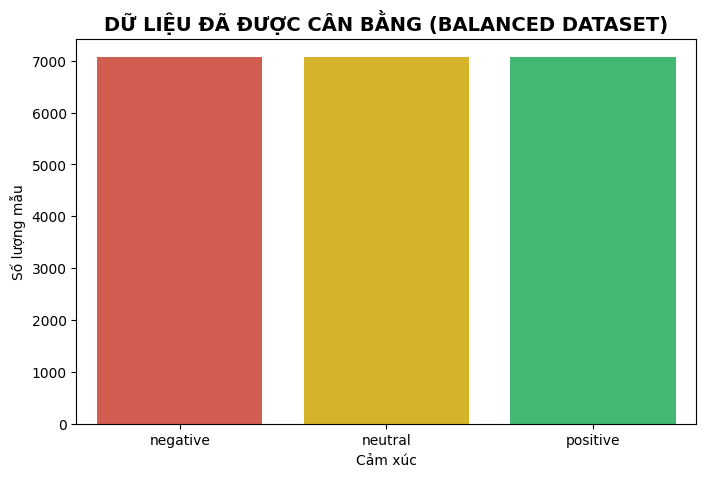

Đã lưu file: 1-VLSP2018-Restaurant-Train-BALANCED.csv


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Thống kê lại
new_counts = df_train_balanced['label'].value_counts()
print(new_counts)

# 2. Vẽ biểu đồ so sánh
plt.figure(figsize=(8, 5))
colors = {'positive': '#2ecc71', 'negative': '#e74c3c', 'neutral': '#f1c40f'}
sns.barplot(x=new_counts.index, y=new_counts.values, palette=colors)
plt.title('DỮ LIỆU ĐÃ ĐƯỢC CÂN BẰNG (BALANCED DATASET)', fontsize=14, fontweight='bold')
plt.xlabel('Cảm xúc')
plt.ylabel('Số lượng mẫu')
plt.show()

# 3. Lưu file để dùng cho ngày mai (Huấn luyện)
df_train_balanced.to_csv('1-VLSP2018-Restaurant-Train-BALANCED.csv', index=False, encoding='utf-8')
print("Đã lưu file: 1-VLSP2018-Restaurant-Train-BALANCED.csv")